383.0418988000001
1046.8599999999997


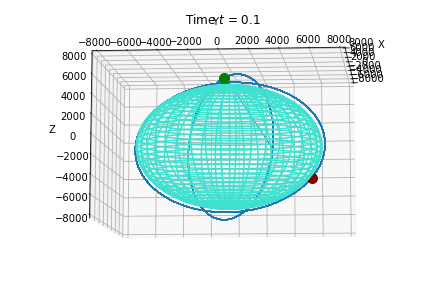

No handles with labels found to put in legend.


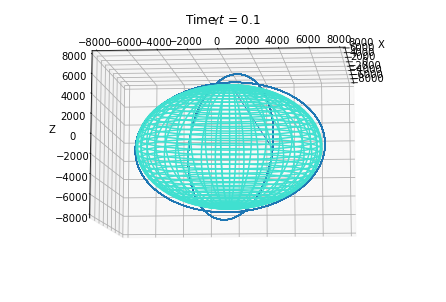

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import math

PI = 3.141592653589793
GM = 3.986005e14
R = 6378.14
M = 5.9737e24

class Satellite(object):
    """Class for Satellite."""
    def __init__(self, mass, eccentricity, semi_major_axis, inclination, true_anomaly):
        super(Satellite, self).__init__()
        self.mass = mass
        self.eccentricity = eccentricity
        self.semi_major_axis = semi_major_axis
        self.inclination = inclination
        self.current_true_anomaly = true_anomaly
        self.elapsed_time = 0
        self.dt = 0.1

    def apogee_in_km(self):
        return self.semi_major_axis * (1+self.eccentricity)

    def perigee_in_km(self):
        return self.semi_major_axis * (1-self.eccentricity)

    def apogee_altitude_in_km(self):
        return self.apogee_in_km() - R

    def perigee_altitude_in_km(self):
        return self.perigee_in_km() - R

    def velocity_at_perigee(self):
        Ra = self.apogee_in_km() * 1000
        Rp = self.perigee_in_km() * 1000
        return math.sqrt(2 * GM * Ra / (Rp * (Ra + Rp)))

    def velocity_at_apogee(self):
        Ra = self.apogee_in_km() * 1000
        Rp = self.perigee_in_km() * 1000
        return math.sqrt(2 * GM * Rp / (Ra * (Ra + Rp)))

    def momentum_at_apogee(self):
        return (self.mass * self.velocity_at_apogee())

    def momentum_at_perigee(self):
        return (self.mass * self.velocity_at_perigee())

    def eccentric_anomaly(self):
        e = self.eccentricity
        mu = math.radians(self.current_true_anomaly)
        return math.acos((e + math.cos(mu)) / (1 + e * math.cos(mu))) # result in radians

    def mean_anomaly(self):
        e = self.eccentricity
        E = self.eccentric_anomaly()
        return E - e * math.sin(E) # result in radians

    def mean_motion(self):
        a = self.semi_major_axis * 1000
        return math.sqrt(GM / math.pow(a, 3))

    def calculate_current_true_anomaly(self):
        # mean anomaly given time step, dt = t - t0, initial angle for the true_anomaly and mean motion, n
        e = self.eccentricity
        Mo = self.mean_anomaly()
        n = self.mean_motion()
        M = Mo + n * (self.dt)
        E = M
        while True:
            dE = (E - e * math.sin(E) - M)/(1 - e * math.cos(E))
            E -= dE
            if abs(dE) < 1e-6:
                break
        mu = math.acos((math.cos(E) - e) / (1 - e * math.cos(E)))
        true_anomaly = math.degrees(mu)
        return true_anomaly
    
    def orbital_radius(self):
        e = self.eccentricity
        m = self.current_true_anomaly
        a = self.semi_major_axis
        r = a*(1-math.pow(e, 2))/1+(e*math.cos(m))
        return r
    
    def compute_current_postion(self):
        self.elapsed_time = self.elapsed_time + self.dt
        self.current_true_anomaly = self.calculate_current_true_anomaly()
        radius = self.orbital_radius()
        return [radius, self.current_true_anomaly, self.inclination, self.elapsed_time, self.eccentricity]
    
    def compute_initial_orbit(self, true_anomaly):
        e = self.eccentricity
        m = true_anomaly
        a = self.semi_major_axis
        r = a*(1-math.pow(e, 2))/1+(e*math.cos(m))
        return [r, true_anomaly, self.inclination]
kuns = Satellite(1, 0.002599, 6778.8, 51.6385, 146.6117) # Satellite(mass, eccentricity, semi_major_axis, inclination, true_anomaly)
dummy_sat = Satellite(1, 0.01, 7500, 145, 69) # Satellite(mass, eccentricity, semi_major_axis, inclination, true_anomaly)
print(kuns.perigee_altitude_in_km())
print(dummy_sat.perigee_altitude_in_km())
def update_satelite_position(number):
    kuns_data = kuns.compute_current_postion()
    dummy_data = dummy_sat.compute_current_postion()
    animate(kuns_data, dummy_data, 'maroon', 'green', '1KUNS-PF', 'Dummy sat')
    # ax.set_title('Two Body Problem simulation: 1KUNS-PF Satellite')
    return number

def animate(data, data1, color, color1, label, label1):
    r = data[0]
    v = data[1]
    i = data[2]
    
    r1 = data1[0]
    v1 = data1[1]
    i1 = data1[2]

    et = str(data[3])

    x = r * math.sin(v) * math.cos(i)
    y = r * math.sin(v) * math.sin(i)
    z = r * math.cos(v)

    x1 = r1 * math.sin(v1) * math.cos(i1)
    y1 = r1 * math.sin(v1) * math.sin(i1)
    z1 = r1 * math.cos(v1)

    # eccentricity = data[4]
    # info = "Eccentricity: {} \nInclination: {}\nTrue Anomaly {} \nElapsed time: {}\n".format(eccentricity, i, v, et)

    coordsX = np.array([x])
    coordsY = np.array([y])
    coordsZ = np.array([z])

    coordsX1 = np.array([x1])
    coordsY1 = np.array([y1])
    coordsZ1 = np.array([z1])

    string = 'Time $t$ = '+str(et)+''
    plt.suptitle(string)
    p = ax.scatter(coordsX, coordsY, coordsZ, c=color, marker='o', zorder=5, s=100, label=label)
    n = ax.scatter(coordsX1, coordsY1, coordsZ1, c=color1, marker='o', zorder=7, s=100, label=label1)
    plt.pause(0.01)
    plt.legend(loc=2)
    p.remove()
    n.remove()
    

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Setting the axes properties
ax.set_xlim3d([-8000, 8000.0])
ax.set_xlabel('X')

ax.set_ylim3d([-8000, 8000.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-8000, 8000.0])
ax.set_zlabel('Z')

# ax.set_title('Two Body Problem simulation: 1KUNS-PF Satellite')
xvalues = []
yvalues = []
zvalues = []
rvalues = []

for angle in np.arange(0.0, 360.0, 0.1):
    data = dummy_sat.compute_initial_orbit(angle)
    r = data[0]
    v = data[1]
    i = data[2]
    x = r * math.sin(v) * math.cos(i)
    y = r * math.sin(v) * math.sin(i)
    z = r * math.cos(v)
    xvalues.append(x)
    yvalues.append(y)
    zvalues.append(z)
    rvalues.append(r)

coordsX = np.array(xvalues)
coordsY = np.array(yvalues)
coordsZ = np.array(zvalues)
orbit = ax.plot(coordsX, coordsY, coordsZ, linewidth=1, color='black', label='dummy orbit')

df = pd.DataFrame({"X-coordinate" : coordsX, "Y-coordinate" : coordsY, "Z-coordinate" : coordsZ, "r-value" : rvalues})
df.to_csv("dummy-sat.csv", index=False)

for angle in np.arange(0.0, 360.0, 0.1):
    data = kuns.compute_initial_orbit(angle)
    r = data[0]
    v = data[1]
    i = data[2]
    x = r * math.sin(v) * math.cos(i)
    y = r * math.sin(v) * math.sin(i)
    z = r * math.cos(v)
    xvalues.append(x)
    yvalues.append(y)
    zvalues.append(z)
    rvalues.append(r)

coordsX = np.array(xvalues)
coordsY = np.array(yvalues)
coordsZ = np.array(zvalues)
orbit = ax.plot(coordsX, coordsY, coordsZ, linewidth=1, label='1kuns-pf orbit')
df = pd.DataFrame({"X-coordinate" : coordsX, "Y-coordinate" : coordsY, "Z-coordinate" : coordsZ, "r-value" : rvalues})
df.to_csv("kuns-pf.csv", index=False)



# Make earth data
# a = Equatorial radius (6378.1370 km)
# b = Polar radius (6356.7523 km)
u = np.linspace(0, 2 * np.pi, 40)
v = np.linspace(0, np.pi, 40)
x = 6378.1370 * np.outer(np.cos(u), np.sin(v))
y = 6356.7523 * np.outer(np.sin(u), np.sin(v))
z = 6378.1370 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the earth surface
earth = ax.plot_wireframe(x, y, z, color='turquoise', label='earth')
ax.view_init(elev=-10., azim=5.)


# Creating the Animation object
satellite_ani = animation.FuncAnimation(fig, update_satelite_position, 12, interval=1, blit=False)

plt.show()